In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import os
import json

# %%
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = '1'

c:\AIWorkspace\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [3]:
DATA_IN_PATH = './data-in/'
DATA_OUT_PATH = './data-out/'
INPUT_TRAIN_DATA = 'nsmc_train_input.npy'
LABEL_TRAIN_DATA = 'nsmc_train_label.npy'
DATA_CONFIGS = 'nsmc_data_configs.json'

In [4]:
train_input = np.load(open(DATA_IN_PATH + INPUT_TRAIN_DATA, 'rb'))
train_label = np.load(open(DATA_IN_PATH + LABEL_TRAIN_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [5]:
model_name = 'cnn_classifier_kr'
BATCH_SIZE = 512
NUM_EPOCHS = 10
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name': model_name,
        'vocab_size': prepro_configs['vocab_size'],
        'embedding_size': 128,
        'num_filters': 100,
        'dropout_rate': 0.5,
        'hidden_dimension': 250,
        'output_dimension':1}

In [6]:
class CNNClassifier(tf.keras.Model):
    
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size']+1,
                                     output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'],
                                   kernel_size=kernel_size,
                                   padding='valid',
                                   activation='relu',
                                   kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
                                      #MaxNorm(max_value=3.) 커널의 가중치값이 최대 값 3을 넘지 않게 설정
                         for kernel_size in [3,4,5]]
        self.pooling = layers.GlobalMaxPooling1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['hidden_dimension'],
                           activation='relu',
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                           activation='sigmoid',
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [7]:
model = CNNClassifier(**kargs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=5)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = DATA_OUT_PATH + model_name + '/.weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

In [9]:
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))

./data-out/cnn_classifier_kr -- Folder create complete 



In [10]:
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

In [11]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7443 - loss: 0.5054
Epoch 1: val_accuracy improved from None to 0.82073, saving model to ./data-out/cnn_classifier_kr/.weights.h5

Epoch 1: finished saving model to ./data-out/cnn_classifier_kr/.weights.h5
264/264 ━━━━━━━━━━━━━━━━━━━━ 40s 136ms/step - accuracy: 0.7939 - loss: 0.4353 - val_accuracy: 0.8207 - val_loss: 0.3921
Epoch 2/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.8784 - loss: 0.2937
Epoch 2: val_accuracy improved from 0.82073 to 0.82727, saving model to ./data-out/cnn_classifier_kr/.weights.h5

Epoch 2: finished saving model to ./data-out/cnn_classifier_kr/.weights.h5
264/264 ━━━━━━━━━━━━━━━━━━━━ 47s 176ms/step - accuracy: 0.8753 - loss: 0.2982 - val_accuracy: 0.8273 - val_loss: 0.3896
Epoch 3/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9338 - loss: 0.1773
Epoch 3: val_accuracy did not improve from 0.82727
264/264 ━━━━━━━━━━━━━━━━━━━━ 42s 158ms/step - accuracy: 0.9303 - loss:

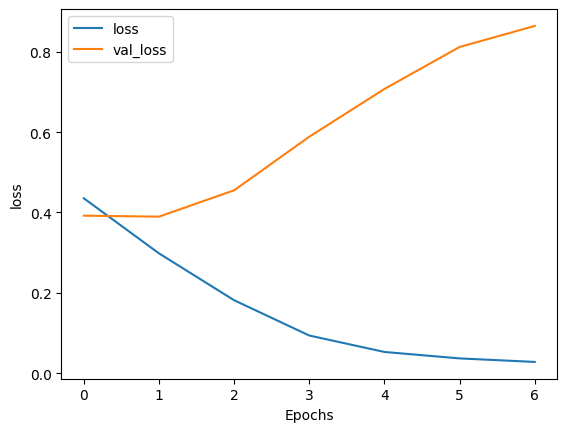

In [12]:
plot_graphs(history, 'loss')

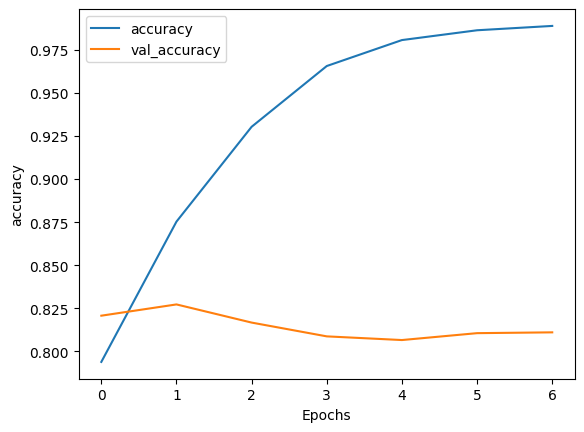

In [13]:
plot_graphs(history, 'accuracy')

In [14]:
DATA_OUT_PATH = './data-out/'
INPUT_TEST_DATA = 'nsmc_test_input.npy'
LABEL_TEST_DATA = 'nsmc_test_label.npy'
SAVE_FILE_NM = '.weights.h5' #저장된 best model 이름

test_input = np.load(open(DATA_IN_PATH + INPUT_TEST_DATA, 'rb'))
test_label_data = np.load(open(DATA_IN_PATH + LABEL_TEST_DATA, 'rb'))

In [15]:
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [16]:
model.evaluate(test_input, test_label_data)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8287 - loss: 0.3895


[0.38948145508766174, 0.8286600112915039]